# Zadanie 5 — Asymilacja danych: ABC i 3D-Var (modele PDE i ODE)

Cel:
- Wygenerować „rzeczywiste” dane z modelu PDE (trajektoria TB(t) + szum pomiarowy).
- Przeprowadzić asymilację na modelach ODE i, opcjonalnie, PDE dwoma metodami: ABC i 3D-Var.
- Sprawdzić jakość predykcji w przód (poza oknem obserwacji) i w tył (przed oknem obserwacji).
- Raportować wyniki dla trzech budżetów obliczeniowych: mały, średni, duży.
Zapisy: wykresy → `figs/`, tabele/JSON → `out/`.

In [22]:
import os, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Path("figs").mkdir(exist_ok=True)
Path("out").mkdir(exist_ok=True)

# SciPy: integracja ODE i optymalizacja
try:
    from scipy.integrate import solve_ivp
    from scipy.optimize import minimize
    SCIPY_OK = True
except Exception as e:
    SCIPY_OK = False
    print("Uwaga: SciPy niedostępny -> 3D-Var/solve_ivp mogą nie działać:", e)

def savefig_f(fname, dpi=160):
    if not str(fname).startswith("figs/"):
        fname = f"figs/{fname}"
    plt.savefig(fname, dpi=dpi, bbox_inches="tight")
    print(f"[Zapisano wykres] {fname}")

def save_json(obj, path):
    if not str(path).startswith("out/"):
        path = f"out/{path}"
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)
    print(f"[Zapisano JSON] {path}")

In [23]:
from dataclasses import dataclass

@dataclass
class ODEParams:
    rho_S: float = 0.04
    rho_R: float = 0.03
    K: float = 1.0
    alpha_S: float = 0.8
    alpha_R: float = 0.12
    sigma: float = 0.05
    delta: float = 0.1
    gamma_S: float = 0.02
    gamma_R: float = 0.02
    lam: float = 0.2
    beta: float = 0.0
    mu_max: float = 0.05
    C50: float = 0.2
    m_hill: int = 3
    dose_type: str = "bolus_periodic"   # 'bolus_periodic' | 'infusion_const' | 'none'
    dose_A: float = 1.0
    dose_period: float = 5.0
    infusion_rate: float = 0.0

def mu_of_C(C, mu_max, C50, m):
    Cn = max(C, 0.0)
    ratio = (Cn / (C50 + 1e-12))**m
    return mu_max * (ratio / (1.0 + ratio))

def dosing_term_exact(t, dt, period, A):
    tau = 0.01 * period
    t0 = (t // period) * period
    start, end = t0, t0 + tau
    overlap = max(0.0, min(t+dt, end) - max(t, start))
    return (A / tau) * (overlap / max(dt, 1e-12))

def ode_rhs(t, y, p: ODEParams, dt_for_dose):
    S, R, I, C = y
    N = S + R
    dS = p.rho_S * S * (1 - N/p.K) - p.alpha_S*C*S - p.gamma_S*I*S
    dR = p.rho_R * R * (1 - N/p.K) - p.alpha_R*C*R - p.gamma_R*I*R
    mu = mu_of_C(C, p.mu_max, p.C50, p.m_hill)
    dS -= mu * S
    dR += mu * S
    dI = p.sigma * N - p.delta * I
    dC = - p.lam * C - p.beta * C * N
    if p.dose_type == "infusion_const":
        I_in = p.infusion_rate
    elif p.dose_type == "bolus_periodic":
        I_in = dosing_term_exact(t, dt_for_dose, p.dose_period, p.dose_A)
    else:
        I_in = 0.0
    dC += I_in
    return np.array([dS, dR, dI, dC], dtype=float)

def simulate_ode(p: ODEParams, y0, t_eval):
    dt = np.mean(np.diff(t_eval)) if len(t_eval) > 1 else 1e-2
    def fun(t, y): return ode_rhs(t, y, p, dt)
    sol = solve_ivp(fun, (t_eval[0], t_eval[-1]), y0, t_eval=t_eval, rtol=1e-7, atol=1e-9)
    if not sol.success:
        raise RuntimeError(sol.message)
    Y = sol.y.T
    S, R, I, C = Y[:,0], Y[:,1], Y[:,2], Y[:,3]
    TB = S + R
    return {"t": t_eval, "S": S, "R": R, "I": I, "C": C, "TB": TB}

## Dane „rzeczywiste” z PDE oraz wybór okna obserwacji
- Próbujemy załadować Twój moduł PDE (z Zadania 2).
- Jeśli jest dostępny, generujemy „true” TB(t) z PDE w horyzoncie `[0, T_end]`, a następnie tworzymy obserwacje z szumem Gaussa.
- Te same obserwacje wykorzystamy do asymilacji ODE (celowo) — ODE ma się dopasować do danych PDE.

[Zapisano trajektorię] out/explicit_Nx96_Ny96_traj.csv
[Zapisano metadane] out/explicit_Nx96_Ny96_info.json
[Zapisano macierz] out/explicit_Nx96_Ny96_S_final.npy
[Zapisano macierz] out/explicit_Nx96_Ny96_R_final.npy
[Zapisano macierz] out/explicit_Nx96_Ny96_I_final.npy
[Zapisano macierz] out/explicit_Nx96_Ny96_C_final.npy


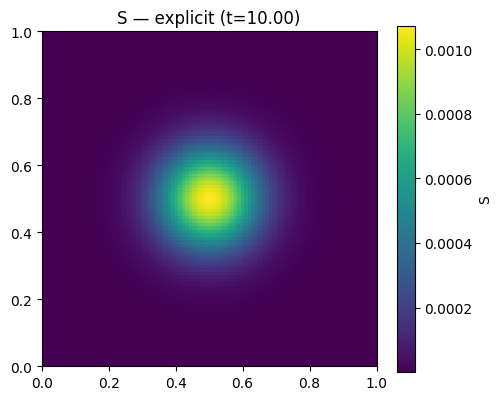

[Zapisano wykres] figs/explicit_S_final.png


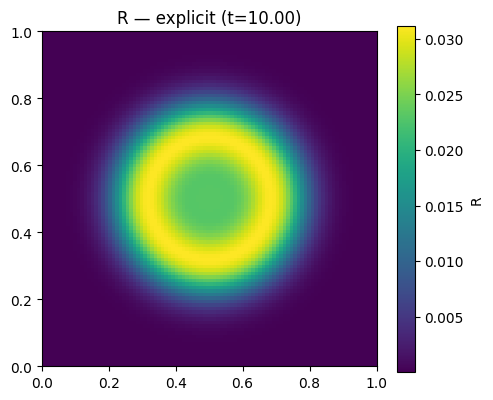

[Zapisano wykres] figs/explicit_R_final.png


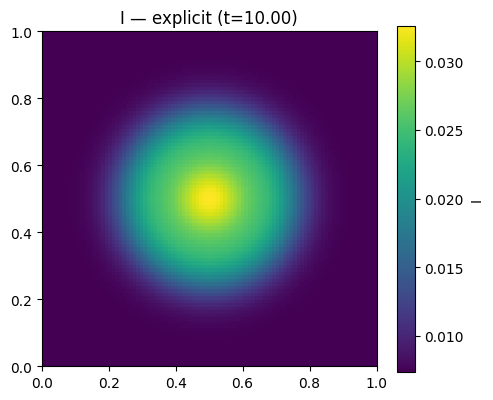

[Zapisano wykres] figs/explicit_I_final.png


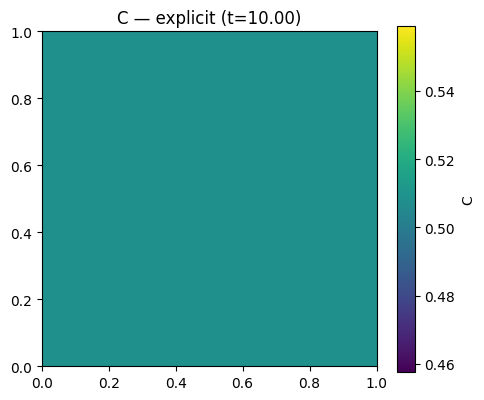

[Zapisano wykres] figs/explicit_C_final.png
[Zapisano trajektorię] out/semi_implicit_Nx96_Ny96_traj.csv
[Zapisano metadane] out/semi_implicit_Nx96_Ny96_info.json
[Zapisano macierz] out/semi_implicit_Nx96_Ny96_S_final.npy
[Zapisano macierz] out/semi_implicit_Nx96_Ny96_R_final.npy
[Zapisano macierz] out/semi_implicit_Nx96_Ny96_I_final.npy
[Zapisano macierz] out/semi_implicit_Nx96_Ny96_C_final.npy


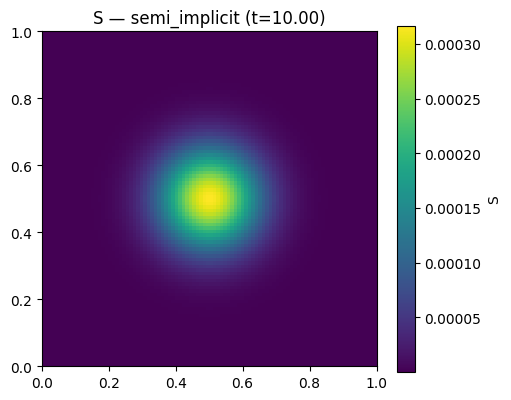

[Zapisano wykres] figs/semi_implicit_S_final.png


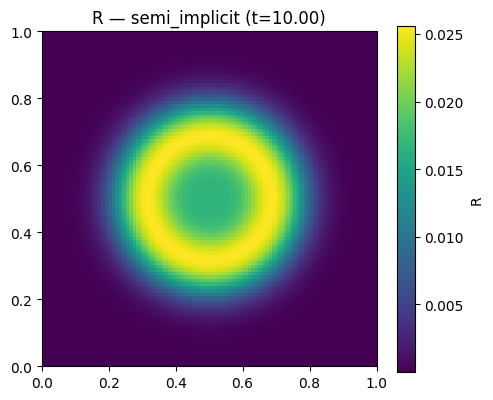

[Zapisano wykres] figs/semi_implicit_R_final.png


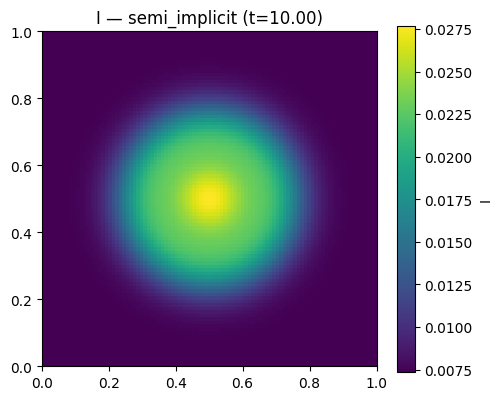

[Zapisano wykres] figs/semi_implicit_I_final.png


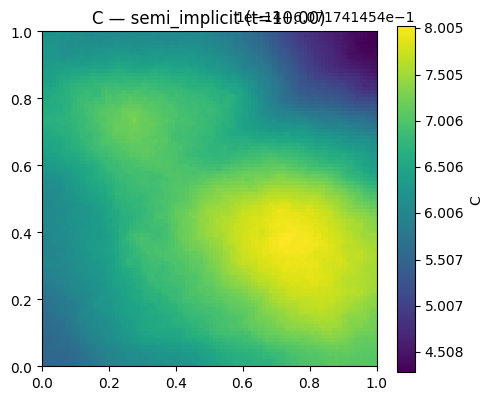

[Zapisano wykres] figs/semi_implicit_C_final.png
[Zapisano wykres] figs/compare_tb.png


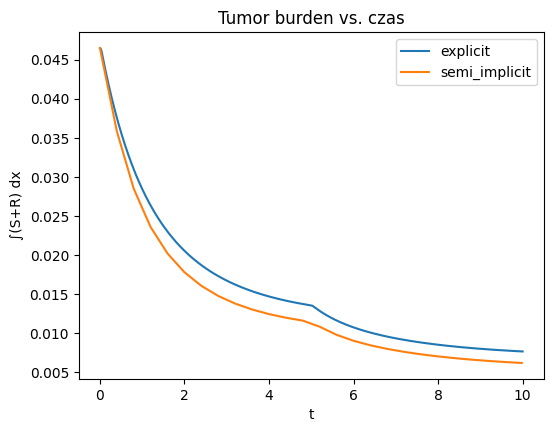

[explicit] N=64  dt=9.070e-04  time=0.72s  TB=0.01344
[semi_implicit] N=64  dt=2.000e-02  time=1.23s  TB=0.01149
[explicit] N=96  dt=3.989e-04  time=3.32s  TB=0.01357
[semi_implicit] N=96  dt=2.000e-02  time=3.22s  TB=0.01149
[explicit] N=128  dt=2.232e-04  time=8.76s  TB=0.01358
[semi_implicit] N=128  dt=2.000e-02  time=6.77s  TB=0.01149
[Zapisano] out/benchmark_resolutions.csv
[Zapisano wykres] figs/benchmark_time_vs_N.png


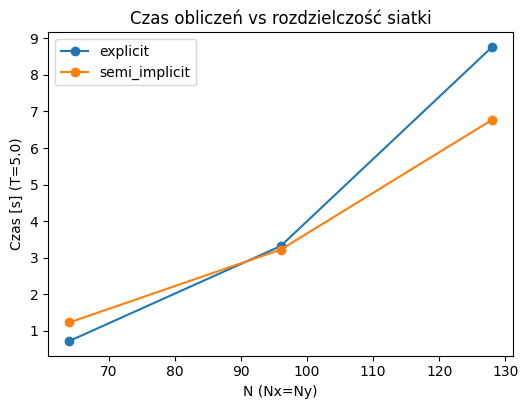

[explicit] dt=1.008e-03 steps=4962 time=0.66s
[explicit] dt=6.719e-04 steps=7442 time=0.97s
[explicit] dt=5.039e-04 steps=9923 time=1.29s
[explicit] dt=3.359e-04 steps=14884 time=1.95s
[Zapisano wykres] figs/stability_vs_dt_explicit.png


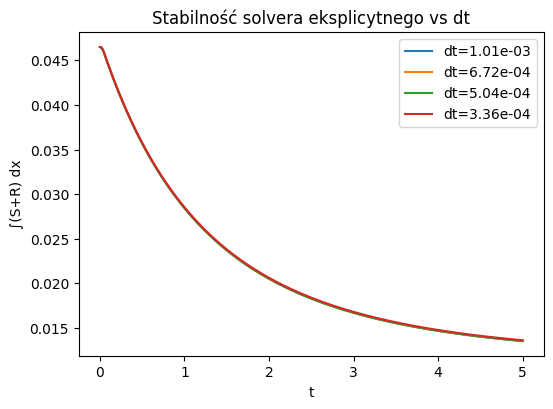

D_C=0.005 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
D_C=0.01 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
D_C=0.02 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
D_C=0.03 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
alpha_S=0.4 -> TB_final=0.01855 (solver=semi_implicit, dt=2.000e-02)
alpha_S=0.8 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
alpha_S=1 -> TB_final=0.01027 (solver=semi_implicit, dt=2.000e-02)
alpha_S=1.2 -> TB_final=0.00962 (solver=semi_implicit, dt=2.000e-02)
mu_max=0 -> TB_final=0.01016 (solver=semi_implicit, dt=2.000e-02)
mu_max=0.02 -> TB_final=0.01071 (solver=semi_implicit, dt=2.000e-02)
mu_max=0.05 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
mu_max=0.1 -> TB_final=0.01268 (solver=semi_implicit, dt=2.000e-02)
[Zapisano] out/param_sweep_basic.csv
[Zapisano wykres] figs/param_Dc_tb.png


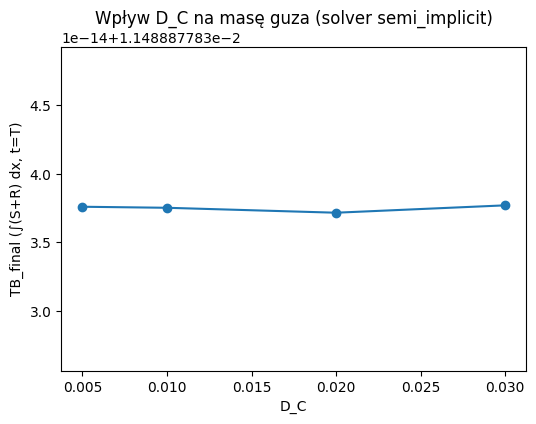

[Zapisano wykres] figs/param_alphaS_tb.png


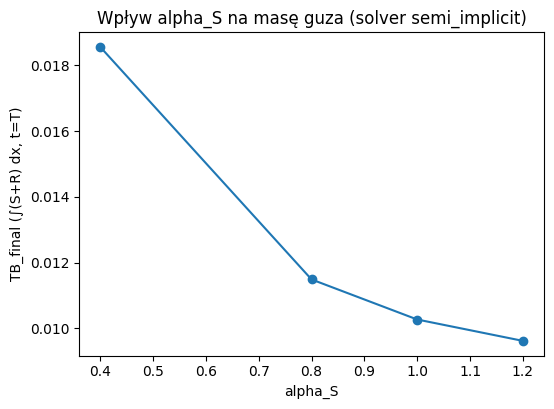

[Zapisano wykres] figs/param_mu_tb.png


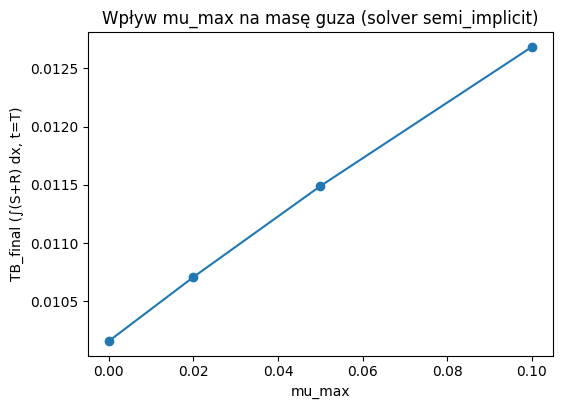

[Zapisano trajektorię] out/compare_explicit_N96_traj.csv
[Zapisano metadane] out/compare_explicit_N96_info.json
[Zapisano macierz] out/compare_explicit_N96_S_final.npy
[Zapisano macierz] out/compare_explicit_N96_R_final.npy
[Zapisano macierz] out/compare_explicit_N96_I_final.npy
[Zapisano macierz] out/compare_explicit_N96_C_final.npy
[Tworzenie GIF dla explicit...]
  Liczba klatek: 64, dt=0.000399, save_every=400
[Zapisano animację] figs/compare_explicit_animation.gif
[Zapisano wykres] figs/compare_explicit_all_fields_final.png


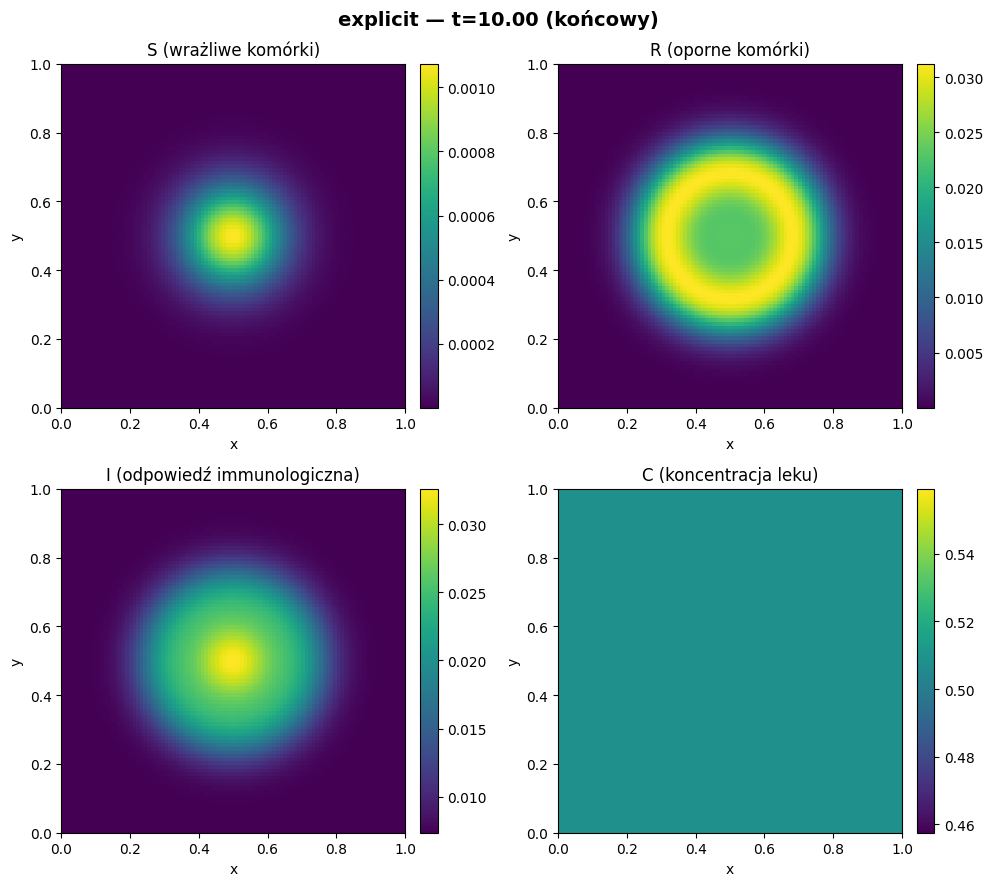

[Zapisano trajektorię] out/compare_semi_implicit_N96_traj.csv
[Zapisano metadane] out/compare_semi_implicit_N96_info.json
[Zapisano macierz] out/compare_semi_implicit_N96_S_final.npy
[Zapisano macierz] out/compare_semi_implicit_N96_R_final.npy
[Zapisano macierz] out/compare_semi_implicit_N96_I_final.npy
[Zapisano macierz] out/compare_semi_implicit_N96_C_final.npy
[Tworzenie GIF dla semi_implicit...]
  Liczba klatek: 26, dt=0.020000, save_every=20
[Zapisano animację] figs/compare_semi_implicit_animation.gif
[Zapisano wykres] figs/compare_semi_implicit_all_fields_final.png


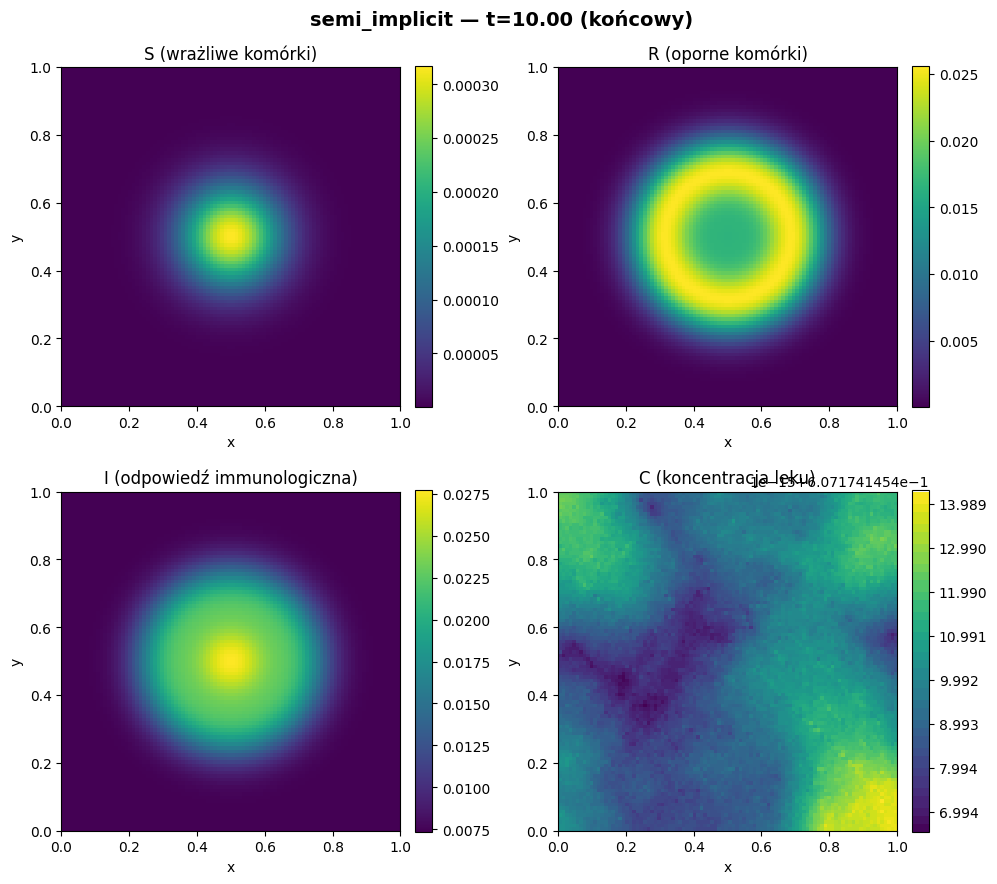

[Zapisano wykres] figs/compare_solvers_tb.png


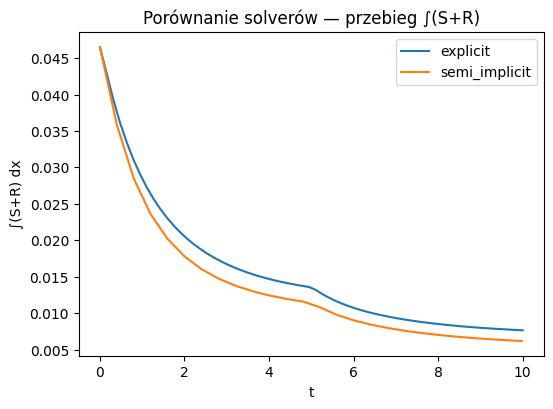


Generating Bolus Dosing Animation
Running semi_implicit simulation with T=10.0 to capture 3 bolus doses...
Bolus doses at t=0, 5, 10 with dose_period=5.0
Simulation complete: 35 frames, dt=0.020000
Creating animation frames...
  Frame 1/35: t=0.00
  Frame 6/35: t=1.50
  Frame 11/35: t=3.00
  Frame 16/35: t=4.50
  Frame 21/35: t=6.00
  Frame 26/35: t=7.50
  Frame 31/35: t=9.00

Saving GIF animation...
[Zapisano] figs/bolus_periodic_dosing_animation.gif
Animation contains 35 frames showing bolus doses at t=0, 5, 10
Relatywna różnica krzywych TB (norma 2): 1.692e-14
[Zapisano] out/compare_solvers_same_dt.csv
[Zapisano wykres] figs/compare_solvers_same_dt.png


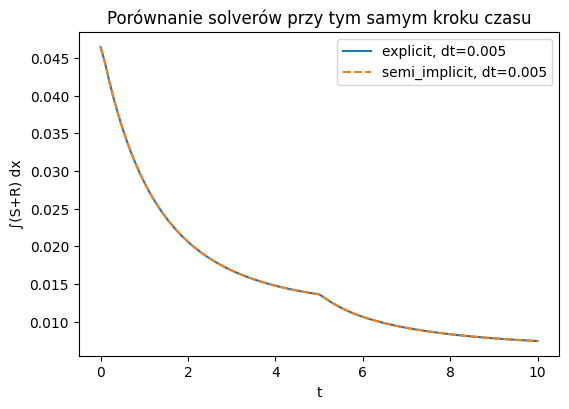

[Zapisano wykres] figs/compare_solvers_same_dt_diff.png


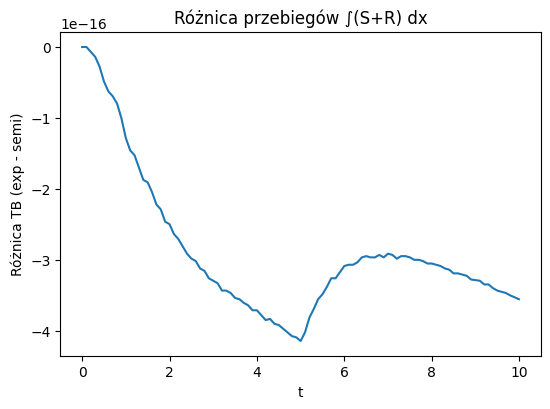

D_C=0.005 -> TB_final=0.02611
D_C=0.01 -> TB_final=0.02625
D_C=0.02 -> TB_final=0.02656
D_C=0.03 -> TB_final=0.02680
D_C=0.05 -> TB_final=0.02711
[Zapisano] out/robin_beta_sweep_Dc.csv
[Zapisano wykres] figs/robin_beta_Dc_influence.png


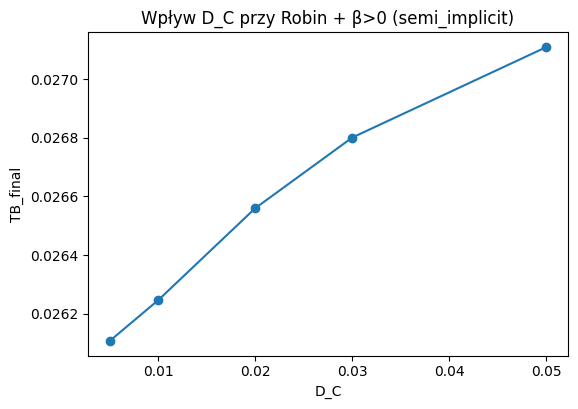

alpha_S=0.4 [LO] -> TB_final=0.00835, time=2.48s
alpha_S=1.2 [HI] -> TB_final=0.00576, time=2.46s
mu_max=0.0 [LO] -> TB_final=0.00509, time=2.46s
mu_max=0.1 [HI] -> TB_final=0.00718, time=2.47s
lam=0.05 [LO] -> TB_final=0.00303, time=2.45s
lam=0.5 [HI] -> TB_final=0.01176, time=2.48s
sigma=0.0 [LO] -> TB_final=0.00623, time=2.45s
sigma=0.1 [HI] -> TB_final=0.00620, time=2.47s
[Zapisano] out/extremes_summary.csv
[Zapisano wykres] figs/extremes_tb_bar.png


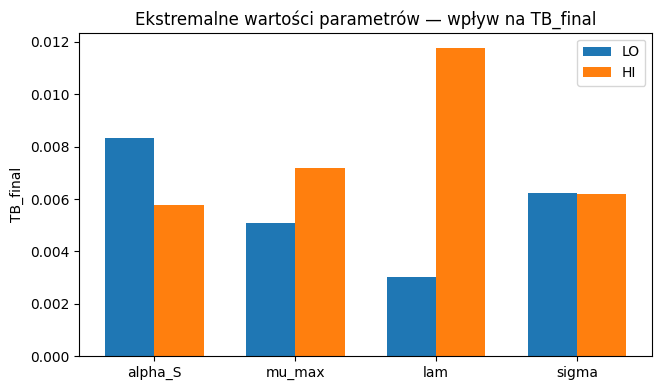

[Zapisano wykres] figs/panel_maps_explicit.png
[Zapisano wykres] figs/panel_maps_semi_implicit.png
[Zapisano wykres] figs/panel_tb_compare.png


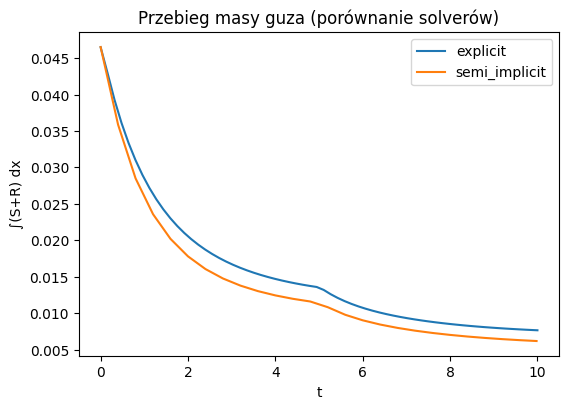

[OK] Załadowano model PDE.
[Zapisano] out/da_observations.csv


In [24]:
# Wczytaj implementację PDE (jeśli masz plik z Zadania 2 w katalogu roboczym)
PDE_OK = True
try:
    import importlib.util, sys
    candidates = [
        "2_tumor_diffusion_pde_analysis.py"
    ]
    mod = None
    for cand in candidates:
        if Path(cand).exists():
            spec = importlib.util.spec_from_file_location("pdemod", cand)
            pdemod = importlib.util.module_from_spec(spec)
            sys.modules["pdemod"] = pdemod
            spec.loader.exec_module(pdemod)
            mod = pdemod
            break
    if mod is None:
        raise FileNotFoundError("Brak pliku modułu PDE.")
    Grid = mod.Grid; Params = mod.Params; run_simulation = mod.run_simulation
    p_true = mod.p  # bazowy zestaw parametrów jako „ukryte prawdziwe” (możesz zmienić)
    print("[OK] Załadowano model PDE.")
except Exception as e:
    PDE_OK = False
    print("Uwaga: PDE niedostępne w tym notebooku:", e)

# Ustal horyzont i siatkę czasu dla „prawdy" i obserwacji
T_end = 10.0  # Extended from 6.0 to cover three boluses (t=0, 5, 10)
t_true = np.linspace(0.0, T_end, 201)  # co 0.05 (was 121 for T=6.0)
obs_sigma = 0.0005                      # szum pomiarowy TB
np.random.seed(123)

if PDE_OK:
    grid = Grid(Nx=64, Ny=64, Lx=1.0, Ly=1.0)
    (S_end, R_end, I_end, C_end), traj, info = run_simulation(
        solver_name="semi_implicit", grid=grid, p=p_true, T=T_end, dt=None, save_every=max(1, len(t_true)//120), theta=0.5
    )
    t_traj = np.array([row["t"] for row in traj])
    TB_traj = np.array([row["tumor_burden"] for row in traj])
    # Interpolacja do t_true
    TB_true = np.interp(t_true, t_traj, TB_traj)
else:
    # Fallback: użyj ODE jako „prawdy” (jeśli PDE niedostępne)
    TB0 = 0.0465
    y0_true = np.array([0.9*TB0, 0.1*TB0, 0.02, 0.0])
    p_alt = ODEParams()
    sim_true = simulate_ode(p_alt, y0_true, t_true)
    TB_true = sim_true["TB"]

# Generujemy obserwacje z szumem
y_obs = TB_true + obs_sigma * np.random.randn(len(TB_true))

# Zapis do out/
pd.DataFrame({"t": t_true, "TB_true": TB_true, "TB_obs": y_obs}).to_csv("out/da_observations.csv", index=False)
print("[Zapisano] out/da_observations.csv")

## Okno obserwacji i miary jakości
Wybieramy podokno obserwacji `[t_obs_start, t_obs_end]` wewnątrz `[0,T_end]`. 
- **Asymilacja** używa tylko obserwacji w tym oknie. 
- **Predykcja w przód**: porównujemy model na `(t_obs_end, T_end]`. 
- **Predykcja w tył**: porównujemy model na `[0, t_obs_start)`.
Miary: RMSE oraz MAE na TB(t).

In [25]:
t_obs_start, t_obs_end = 1.0, 4.0  # można zmienić; okno środkowe
mask_obs = (t_true >= t_obs_start) & (t_true <= t_obs_end)
mask_fwd = (t_true > t_obs_end)
mask_bwd = (t_true < t_obs_start)

def rmse(a,b): 
    a, b = np.asarray(a), np.asarray(b)
    return float(np.sqrt(np.mean((a-b)**2)))

def mae(a,b):
    a, b = np.asarray(a), np.asarray(b)
    return float(np.mean(np.abs(a-b)))

## Asymilacja na ODE
Parametry do estymacji: $(\alpha_S, \mu_{\max}, \lambda)$ z ograniczeniami (priory).  
Warunki początkowe: $S_0=0.9\,TB(0),\ R_0=0.1\,TB(0),\ I_0=0.02,\ C_0=0$.  
Operator obserwacji: $H(y)=S+R$ (TB). Odległość w ABC: RMSE na TB w punktach obserwacji.  
W 3D-Var minimalizujemy koszt: $J(\theta)=\| \theta-\theta_b\|_{B^{-1}}^2 + \sum (H(M(\theta,t_k))-y_k)^2/R$, gdzie $B$ i $R$ to macierze kowariancji (tu diagonalne).

In [26]:
# Priory na parametry (jednolite w przedziałach)
prior_bounds = {
    "alpha_S": (0.4, 1.2),
    "mu_max": (0.0, 0.1),
    "lam":     (0.05, 0.5)
}
param_order = ["alpha_S","mu_max","lam"]

# t dla symulacji modeli podczas dopasowania: używamy dokładnie t_true
TB0 = float(TB_true[0])
y0_ode = np.array([0.9*TB0, 0.1*TB0, 0.02, 0.0])
p_baseline = ODEParams()

# Ekstrakcja obserwacji w oknie
t_obs = t_true[mask_obs]
y_obs_win = y_obs[mask_obs]

In [27]:
def sample_prior(size):
    X = np.zeros((size, len(param_order)), dtype=float)
    for j, name in enumerate(param_order):
        lo, hi = prior_bounds[name]
        X[:, j] = lo + (hi - lo) * np.random.rand(size)
    return X

def simulate_TB_for_params(theta, t_eval):
    p = ODEParams(**vars(p_baseline))
    for val, name in zip(theta, param_order):
        setattr(p, name, float(val))
    sim = simulate_ode(p, y0_ode, t_eval)
    return sim["TB"]

def abc_fit(budget, eps_quantile=0.2, random_seed=1234):
    np.random.seed(random_seed)
    # 1) Losowanie próbek z priory
    Theta = sample_prior(budget)
    # 2) Odległość do obserwacji (RMSE w oknie)
    dists = np.empty(budget, dtype=float)
    for i, th in enumerate(Theta):
        TB_sim = simulate_TB_for_params(th, t_true)  # całe okno czasu
        dists[i] = rmse(TB_sim[mask_obs], y_obs_win)
    # 3) Próg akceptacji
    thr = np.quantile(dists, eps_quantile)
    acc_mask = dists <= thr
    Theta_acc = Theta[acc_mask]
    d_acc = dists[acc_mask]
    if len(Theta_acc) == 0:
        # w skrajnym razie dopuść najlepszą próbkę
        idx = np.argmin(dists)
        Theta_acc = Theta[idx:idx+1]
        d_acc = dists[idx:idx+1]
        thr = float(d_acc[0])
    theta_map = Theta_acc[np.argmin(d_acc)]
    return {
        "Theta_all": Theta, "dists": dists,
        "Theta_acc": Theta_acc, "dists_acc": d_acc,
        "eps": float(thr), "theta_map": theta_map
    }

# Trzy budżety
budgets = {
    "small":  200,
    "medium": 1000,
    "large":  4000
}

abc_results = {}
for k, B in budgets.items():
    print(f"[ABC] Budżet: {k} ({B} próbek)")
    res = abc_fit(B, eps_quantile=0.2, random_seed=1234)
    abc_results[k] = res
    # Zapis JSON (tylko podsumowanie, bez wszystkich próbek aby nie robić dużych plików)
    save_json({
        "budget": k,
        "eps": res["eps"],
        "theta_map": res["theta_map"].tolist(),
        "n_accept": int(res["Theta_acc"].shape[0])
    }, f"out/abc_{k}_summary.json")

[ABC] Budżet: small (200 próbek)
[Zapisano JSON] out/abc_small_summary.json
[ABC] Budżet: medium (1000 próbek)
[Zapisano JSON] out/abc_medium_summary.json
[ABC] Budżet: large (4000 próbek)
[Zapisano JSON] out/abc_large_summary.json


In [28]:
def run_3dvar_window(t_obs_start, t_obs_end, budgets=None):
    """
    Run 3D-Var data assimilation for a specific observation window.

    Args:
        t_obs_start: Start time of observation window
        t_obs_end: End time of observation window
        budgets: Dictionary of budget names to max iterations (default: small, medium, large)

    Returns:
        Dictionary of results for each budget
    """
    if budgets is None:
        budgets = {"small": 50, "medium": 150, "large": 400}

    # Setup masks for this observation window
    mask_obs_win = (t_true >= t_obs_start) & (t_true <= t_obs_end)
    mask_fwd_win = (t_true > t_obs_end)
    mask_bwd_win = (t_true < t_obs_start)

    # Extract observations in this window
    y_obs_win = y_obs[mask_obs_win]

    # Background (prior) parameters and error covariances
    theta_b = np.array([0.8, 0.05, 0.2])  # background values
    B_std = np.array([0.3, 0.05, 0.15])   # a priori standard deviations
    R_std = obs_sigma                      # observation error std

    # Cost function for 3D-Var
    def cost_J(theta):
        # Background term
        Jb = np.sum(((theta - theta_b) / B_std)**2)
        # Observation term
        TB_sim = simulate_TB_for_params(theta, t_true)
        innov = (TB_sim[mask_obs_win] - y_obs_win) / R_std
        Jo = np.sum(innov**2)
        return 0.5 * (Jb + Jo)

    # Parameter bounds
    bounds = [(prior_bounds[n][0], prior_bounds[n][1]) for n in param_order]

    # Run optimization for each budget
    var_results = {}
    for k, maxit in budgets.items():
        print(f"[3D-Var] Window [{t_obs_start}, {t_obs_end}], Budget: {k} (max iter={maxit})")
        opt = minimize(cost_J, theta_b, method="L-BFGS-B", bounds=bounds,
                      options={"maxiter": maxit, "ftol": 1e-10})
        theta_opt = opt.x

        # Store results
        var_results[k] = {
            "theta_opt": theta_opt,
            "J": float(opt.fun),
            "nit": int(opt.nit),
            "success": bool(opt.success),
            "mask_obs": mask_obs_win,
            "mask_fwd": mask_fwd_win,
            "mask_bwd": mask_bwd_win
        }

        # Save to file with window identifier
        save_json({
            "budget": k,
            "window": [t_obs_start, t_obs_end],
            "theta_opt": theta_opt.tolist(),
            "J": float(opt.fun),
            "nit": int(opt.nit),
            "success": bool(opt.success)
        }, f"out/3dvar_{k}_window_{int(t_obs_start)}_{int(t_obs_end)}_summary.json")

    return var_results

In [29]:
def cost_J_4dvar(x0, theta_fixed, mask_obs_win, y_obs_win, x0_b, B_std_state, R_std):
    """
    4D-Var cost function optimizing initial state at t=0.

    Args:
        x0: Initial state [S0, R0, I0, C0] at t=0 to optimize
        theta_fixed: Fixed parameters (from 3D-Var or background)
        mask_obs_win: Boolean mask for observation window in t_true
        y_obs_win: Observed tumor burden in observation window
        x0_b: Background initial state at t=0
        B_std_state: Background error std for states
        R_std: Observation error std

    Returns:
        Cost function value J(x0) = 0.5 * (Jb + Jo)
    """
    # Background term on initial state
    Jb = np.sum(((x0 - x0_b) / B_std_state)**2)

    # Forward integration from x0 at t=0 through FULL time horizon
    p = ODEParams(**vars(p_baseline))
    for val, name in zip(theta_fixed, param_order):
        setattr(p, name, float(val))

    # Simulate ODE from t=0 to T=10 to get full trajectory
    sim = simulate_ode(p, x0, t_true)
    TB_sim_full = sim["TB"]

    # Extract observations ONLY in the observation window
    TB_sim_obs = TB_sim_full[mask_obs_win]

    # Observation term (fit only within window)
    innov = (TB_sim_obs - y_obs_win) / R_std
    Jo = np.sum(innov**2)

    return 0.5 * (Jb + Jo)


def run_4dvar(mask_obs_win, y_obs_win, theta_fixed, x0_guess, B_std_state, R_std, max_iter=100):
    """
    Run 4D-Var optimization for initial state at t=0.

    Args:
        mask_obs_win: Boolean mask for observation window in t_true
        y_obs_win: Observed tumor burden in observation window
        theta_fixed: Fixed parameters (α_S, μ_max, λ)
        x0_guess: Initial guess for state [S0, R0, I0, C0] at t=0
        B_std_state: Background error std for states
        R_std: Observation error std
        max_iter: Maximum number of iterations

    Returns:
        Dictionary with optimization results and full trajectory
    """
    # Bounds: all states must be non-negative
    bounds = [(0.0, None)] * 4

    # Cost function wrapper
    def cost(x0):
        return cost_J_4dvar(x0, theta_fixed, mask_obs_win, y_obs_win,
                           x0_guess, B_std_state, R_std)

    # Optimize
    opt = minimize(cost, x0_guess, method="L-BFGS-B", bounds=bounds,
                  options={"maxiter": max_iter, "ftol": 1e-10})

    # Extract full trajectory on full time grid with optimized initial state at t=0
    p = ODEParams(**vars(p_baseline))
    for val, name in zip(theta_fixed, param_order):
        setattr(p, name, float(val))
    sim_opt = simulate_ode(p, opt.x, t_true)

    return {
        "x0_opt": opt.x,
        "J_opt": float(opt.fun),
        "success": bool(opt.success),
        "nit": int(opt.nit),
        "TB_opt": sim_opt["TB"],
        "S_opt": sim_opt["S"],
        "R_opt": sim_opt["R"],
        "I_opt": sim_opt["I"],
        "C_opt": sim_opt["C"]
    }


def run_4dvar_budgets(t_obs_start, t_obs_end, theta_source="3dvar_win1", budgets=None):
    """
    Run 4D-Var for three budgets and given observation window.

    4D-Var optimizes initial state at t=0, then integrates forward through the full
    time horizon, fitting observations only within the specified window.

    Args:
        t_obs_start: Start time of observation window
        t_obs_end: End time of observation window
        theta_source: Source of fixed parameters ("3dvar_win1", "3dvar_win2", or "background")
        budgets: Dictionary of budget names to max iterations

    Returns:
        Dictionary of results for each budget
    """
    if budgets is None:
        budgets = {"small": 50, "medium": 150, "large": 400}

    # Setup observation window masks
    mask_obs_win = (t_true >= t_obs_start) & (t_true <= t_obs_end)
    y_obs_win = y_obs[mask_obs_win]

    # Get fixed parameters from specified source
    if theta_source == "3dvar_win1":
        theta_fixed = var_results_win1["medium"]["theta_opt"]
    elif theta_source == "3dvar_win2":
        theta_fixed = var_results_win2["medium"]["theta_opt"]
    else:  # background
        theta_fixed = np.array([0.8, 0.05, 0.2])

    # Background initial state at t=0
    # Use the true initial tumor burden from observations
    TB0 = float(TB_true[0])  # True initial tumor burden at t=0

    # Split into sensitive and resistant cells based on typical ratio
    # This is our "background guess" for what the initial state was
    x0_b = np.array([
        0.9 * TB0,   # S0: 90% sensitive
        0.1 * TB0,   # R0: 10% resistant
        0.02,        # I0: baseline immune
        0.0          # C0: no drug initially
    ])

    # Background error standard deviations for states
    # Larger values mean less trust in background, more freedom to optimize
    B_std_state = np.array([
        0.02,   # S uncertainty
        0.01,   # R uncertainty
        0.01,   # I uncertainty
        0.01    # C uncertainty
    ])

    # Run optimization for each budget
    results = {}
    for k, maxit in budgets.items():
        print(f"[4D-Var] Window [{t_obs_start}, {t_obs_end}], Budget: {k} (max iter={maxit})")
        print(f"  Optimizing initial state at t=0, fitting observations in window")

        res = run_4dvar(mask_obs_win, y_obs_win, theta_fixed, x0_b,
                       B_std_state, obs_sigma, max_iter=maxit)
        results[k] = res

        # Save to file with window identifier
        save_json({
            "budget": k,
            "window": [t_obs_start, t_obs_end],
            "theta_source": theta_source,
            "x0_opt": res["x0_opt"].tolist(),
            "J": res["J_opt"],
            "nit": res["nit"],
            "success": res["success"]
        }, f"out/4dvar_{k}_window_{int(t_obs_start)}_{int(t_obs_end)}_summary.json")

    return results

In [30]:
if not SCIPY_OK:
    print("Pominięto 3D-Var i 4D-Var — SciPy brak.")
    var_results_win1 = {}
    var_results_win2 = {}
    fourvar_results_win1 = {}
    fourvar_results_win2 = {}
else:
    # Run 3D-Var for Window 1: [1.0, 4.0] (between 1st and 2nd bolus)
    print("\n" + "="*60)
    print("3D-Var: Window 1 [1.0, 4.0] - Between 1st and 2nd bolus")
    print("="*60)
    var_results_win1 = run_3dvar_window(1.0, 4.0)

    # Run 3D-Var for Window 2: [6.0, 9.0] (after 2nd bolus)
    print("\n" + "="*60)
    print("3D-Var: Window 2 [6.0, 9.0] - After 2nd bolus")
    print("="*60)
    var_results_win2 = run_3dvar_window(6.0, 9.0)

    # Run 4D-Var for Window 1: [1.0, 4.0]
    print("\n" + "="*60)
    print("4D-Var: Window 1 [1.0, 4.0] - Between 1st and 2nd bolus")
    print("="*60)
    fourvar_results_win1 = run_4dvar_budgets(1.0, 4.0, theta_source="3dvar_win1")

    # Run 4D-Var for Window 2: [6.0, 9.0]
    print("\n" + "="*60)
    print("4D-Var: Window 2 [6.0, 9.0] - After 2nd bolus")
    print("="*60)
    fourvar_results_win2 = run_4dvar_budgets(6.0, 9.0, theta_source="3dvar_win2")


3D-Var: Window 1 [1.0, 4.0] - Between 1st and 2nd bolus
[3D-Var] Window [1.0, 4.0], Budget: small (max iter=50)
[Zapisano JSON] out/3dvar_small_window_1_4_summary.json
[3D-Var] Window [1.0, 4.0], Budget: medium (max iter=150)
[Zapisano JSON] out/3dvar_medium_window_1_4_summary.json
[3D-Var] Window [1.0, 4.0], Budget: large (max iter=400)
[Zapisano JSON] out/3dvar_large_window_1_4_summary.json

3D-Var: Window 2 [6.0, 9.0] - After 2nd bolus
[3D-Var] Window [6.0, 9.0], Budget: small (max iter=50)
[Zapisano JSON] out/3dvar_small_window_6_9_summary.json
[3D-Var] Window [6.0, 9.0], Budget: medium (max iter=150)
[Zapisano JSON] out/3dvar_medium_window_6_9_summary.json
[3D-Var] Window [6.0, 9.0], Budget: large (max iter=400)
[Zapisano JSON] out/3dvar_large_window_6_9_summary.json

4D-Var: Window 1 [1.0, 4.0] - Between 1st and 2nd bolus
[4D-Var] Window [1.0, 4.0], Budget: small (max iter=50)
  Optimizing initial state at t=0, fitting observations in window
[Zapisano JSON] out/4dvar_small_windo

In [31]:
def generate_comparison_table():
    """
    Generate comprehensive comparison of 3D-Var vs 4D-Var across both windows.

    Returns:
        DataFrame with metrics for all method/window/budget combinations
    """
    rows = []

    # Window configurations
    windows = [
        (1, 1.0, 4.0, var_results_win1, fourvar_results_win1),
        (2, 6.0, 9.0, var_results_win2, fourvar_results_win2)
    ]

    for window_num, t_start, t_end, var_res, fv_res in windows:
        # Setup masks for this window
        mask_obs_eval = (t_true >= t_start) & (t_true <= t_end)
        mask_fwd_eval = (t_true > t_end)
        mask_bwd_eval = (t_true < t_start)

        for budget in ["small", "medium", "large"]:
            # 3D-Var evaluation
            if budget in var_res:
                theta_3d = var_res[budget]["theta_opt"]
                TB_3d = simulate_TB_for_params(theta_3d, t_true)

                rows.append({
                    "method": "3D-Var",
                    "budget": budget,
                    "window": window_num,
                    "window_range": f"[{t_start}, {t_end}]",
                    "rmse_obs": rmse(TB_3d[mask_obs_eval], TB_true[mask_obs_eval]),
                    "rmse_fwd": rmse(TB_3d[mask_fwd_eval], TB_true[mask_fwd_eval]),
                    "rmse_bwd": rmse(TB_3d[mask_bwd_eval], TB_true[mask_bwd_eval]),
                    "mae_obs": mae(TB_3d[mask_obs_eval], TB_true[mask_obs_eval]),
                    "mae_fwd": mae(TB_3d[mask_fwd_eval], TB_true[mask_fwd_eval]),
                    "mae_bwd": mae(TB_3d[mask_bwd_eval], TB_true[mask_bwd_eval]),
                    "J_opt": var_res[budget]["J"],
                    "nit": var_res[budget]["nit"],
                    "success": var_res[budget]["success"]
                })

            # 4D-Var evaluation
            if budget in fv_res:
                TB_4d = fv_res[budget]["TB_opt"]

                rows.append({
                    "method": "4D-Var",
                    "budget": budget,
                    "window": window_num,
                    "window_range": f"[{t_start}, {t_end}]",
                    "rmse_obs": rmse(TB_4d[mask_obs_eval], TB_true[mask_obs_eval]),
                    "rmse_fwd": rmse(TB_4d[mask_fwd_eval], TB_true[mask_fwd_eval]),
                    "rmse_bwd": rmse(TB_4d[mask_bwd_eval], TB_true[mask_bwd_eval]),
                    "mae_obs": mae(TB_4d[mask_obs_eval], TB_true[mask_obs_eval]),
                    "mae_fwd": mae(TB_4d[mask_fwd_eval], TB_true[mask_fwd_eval]),
                    "mae_bwd": mae(TB_4d[mask_bwd_eval], TB_true[mask_bwd_eval]),
                    "J_opt": fv_res[budget]["J_opt"],
                    "nit": fv_res[budget]["nit"],
                    "success": fv_res[budget]["success"]
                })

    df = pd.DataFrame(rows)
    df.to_csv("out/da_comparison_3dvar_vs_4dvar.csv", index=False)
    print("[Zapisano] out/da_comparison_3dvar_vs_4dvar.csv")
    return df

In [32]:
# Generate comprehensive comparison table
if SCIPY_OK:
    print("\n" + "="*60)
    print("Generating Comprehensive Comparison Table")
    print("="*60)
    df_comparison = generate_comparison_table()
    print("\nComparison Summary:")
    print(df_comparison.to_string())


Generating Comprehensive Comparison Table
[Zapisano] out/da_comparison_3dvar_vs_4dvar.csv

Comparison Summary:
    method  budget  window window_range  rmse_obs  rmse_fwd  rmse_bwd   mae_obs   mae_fwd   mae_bwd       J_opt  nit  success
0   3D-Var   small       1   [1.0, 4.0]  0.001767  0.003056  0.002622  0.001508  0.003043  0.002390  439.107749   10     True
1   4D-Var   small       1   [1.0, 4.0]  0.000311  0.001409  0.005314  0.000256  0.001261  0.004578   49.150630   20     True
2   3D-Var  medium       1   [1.0, 4.0]  0.001767  0.003056  0.002622  0.001508  0.003043  0.002390  439.107749   10     True
3   4D-Var  medium       1   [1.0, 4.0]  0.000311  0.001409  0.005314  0.000256  0.001261  0.004578   49.150630   20     True
4   3D-Var   large       1   [1.0, 4.0]  0.001767  0.003056  0.002622  0.001508  0.003043  0.002390  439.107749   10     True
5   4D-Var   large       1   [1.0, 4.0]  0.000311  0.001409  0.005314  0.000256  0.001261  0.004578   49.150630   20     True
6   3D

In [33]:
def plot_dual_window_comparison(budget="medium"):
    """
    Plot trajectories for both windows side-by-side comparing 3D-Var and 4D-Var.

    Args:
        budget: Which budget to visualize ("small", "medium", or "large")
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Window 1: [1.0, 4.0]
    ax1.plot(t_true, TB_true, "k-", lw=2, label="PDE true", zorder=5)

    # Observations in Window 1
    mask_obs_1 = (t_true >= 1.0) & (t_true <= 4.0)
    ax1.scatter(t_true[mask_obs_1], y_obs[mask_obs_1], c="gray", s=30,
               alpha=0.6, label="obs", zorder=10)

    # 3D-Var Window 1
    if budget in var_results_win1:
        theta_3d_1 = var_results_win1[budget]["theta_opt"]
        TB_3d_1 = simulate_TB_for_params(theta_3d_1, t_true)
        ax1.plot(t_true, TB_3d_1, "--", label="3D-Var", lw=1.5)

    # 4D-Var Window 1
    if budget in fourvar_results_win1:
        TB_4d_1 = fourvar_results_win1[budget]["TB_opt"]
        ax1.plot(t_true, TB_4d_1, ":", label="4D-Var", lw=2)

    ax1.axvspan(1.0, 4.0, alpha=0.1, color="blue", label="assim window")
    ax1.set_xlabel("Time t")
    ax1.set_ylabel("Tumor Burden TB(t)")
    ax1.set_title(f"Window 1: [1.0, 4.0] - {budget} budget")
    ax1.legend(loc="best")
    ax1.grid(True, alpha=0.3)

    # Window 2: [6.0, 9.0]
    ax2.plot(t_true, TB_true, "k-", lw=2, label="PDE true", zorder=5)

    # Observations in Window 2
    mask_obs_2 = (t_true >= 6.0) & (t_true <= 9.0)
    ax2.scatter(t_true[mask_obs_2], y_obs[mask_obs_2], c="gray", s=30,
               alpha=0.6, label="obs", zorder=10)

    # 3D-Var Window 2
    if budget in var_results_win2:
        theta_3d_2 = var_results_win2[budget]["theta_opt"]
        TB_3d_2 = simulate_TB_for_params(theta_3d_2, t_true)
        ax2.plot(t_true, TB_3d_2, "--", label="3D-Var", lw=1.5)

    # 4D-Var Window 2
    if budget in fourvar_results_win2:
        TB_4d_2 = fourvar_results_win2[budget]["TB_opt"]
        ax2.plot(t_true, TB_4d_2, ":", label="4D-Var", lw=2)

    ax2.axvspan(6.0, 9.0, alpha=0.1, color="blue", label="assim window")
    ax2.set_xlabel("Time t")
    ax2.set_ylabel("Tumor Burden TB(t)")
    ax2.set_title(f"Window 2: [6.0, 9.0] - {budget} budget")
    ax2.legend(loc="best")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    savefig_f(f"da_dual_window_comparison_{budget}.png")
    print(f"[Zapisano] figs/da_dual_window_comparison_{budget}.png")


def plot_performance_heatmap(df_comparison, metric="rmse_fwd"):
    """
    Generate heatmap comparing methods across budgets and windows.

    Args:
        df_comparison: DataFrame from generate_comparison_table()
        metric: Which metric to visualize (e.g., "rmse_fwd", "mae_obs")
    """
    import seaborn as sns

    # Create pivot table for heatmap
    pivot = df_comparison.pivot_table(
        index=["method", "window"],
        columns="budget",
        values=metric
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt=".4f", cmap="YlOrRd_r",
                cbar_kws={'label': metric.upper()})
    plt.title(f"{metric.upper()}: 3D-Var vs 4D-Var Comparison")
    plt.ylabel("Method / Window")
    plt.xlabel("Budget")
    plt.tight_layout()
    savefig_f(f"da_heatmap_{metric}.png")
    print(f"[Zapisano] figs/da_heatmap_{metric}.png")


def plot_4dvar_state_evolution(budget="medium", window=1):
    """
    Plot full state evolution (S, R, I, C) from 4D-Var.

    Args:
        budget: Which budget to visualize
        window: Which window (1 or 2)
    """
    res = fourvar_results_win1[budget] if window == 1 else fourvar_results_win2[budget]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    state_vars = [
        ("S_opt", "S - Sensitive cells"),
        ("R_opt", "R - Resistant cells"),
        ("I_opt", "I - Immune cells"),
        ("C_opt", "C - Drug concentration")
    ]

    for ax, (var, label) in zip(axes.flat, state_vars):
        ax.plot(t_true, res[var], "b-", lw=1.5, label="4D-Var")
        ax.set_xlabel("Time t")
        ax.set_ylabel(label)
        ax.grid(True, alpha=0.3)
        ax.legend()

    window_str = "[1.0, 4.0]" if window == 1 else "[6.0, 9.0]"
    plt.suptitle(f"4D-Var State Evolution - Window {window} {window_str}, {budget} budget",
                 fontsize=14)
    plt.tight_layout()
    savefig_f(f"da_4dvar_states_{budget}_win{window}.png")
    print(f"[Zapisano] figs/da_4dvar_states_{budget}_win{window}.png")


Generating Visualization Plots
[Zapisano wykres] figs/da_dual_window_comparison_small.png
[Zapisano] figs/da_dual_window_comparison_small.png
[Zapisano wykres] figs/da_dual_window_comparison_medium.png
[Zapisano] figs/da_dual_window_comparison_medium.png
[Zapisano wykres] figs/da_dual_window_comparison_large.png
[Zapisano] figs/da_dual_window_comparison_large.png
[Zapisano wykres] figs/da_heatmap_rmse_fwd.png
[Zapisano] figs/da_heatmap_rmse_fwd.png
[Zapisano wykres] figs/da_heatmap_rmse_obs.png
[Zapisano] figs/da_heatmap_rmse_obs.png
[Zapisano wykres] figs/da_heatmap_mae_fwd.png
[Zapisano] figs/da_heatmap_mae_fwd.png
[Zapisano wykres] figs/da_4dvar_states_medium_win1.png
[Zapisano] figs/da_4dvar_states_medium_win1.png
[Zapisano wykres] figs/da_4dvar_states_medium_win2.png
[Zapisano] figs/da_4dvar_states_medium_win2.png


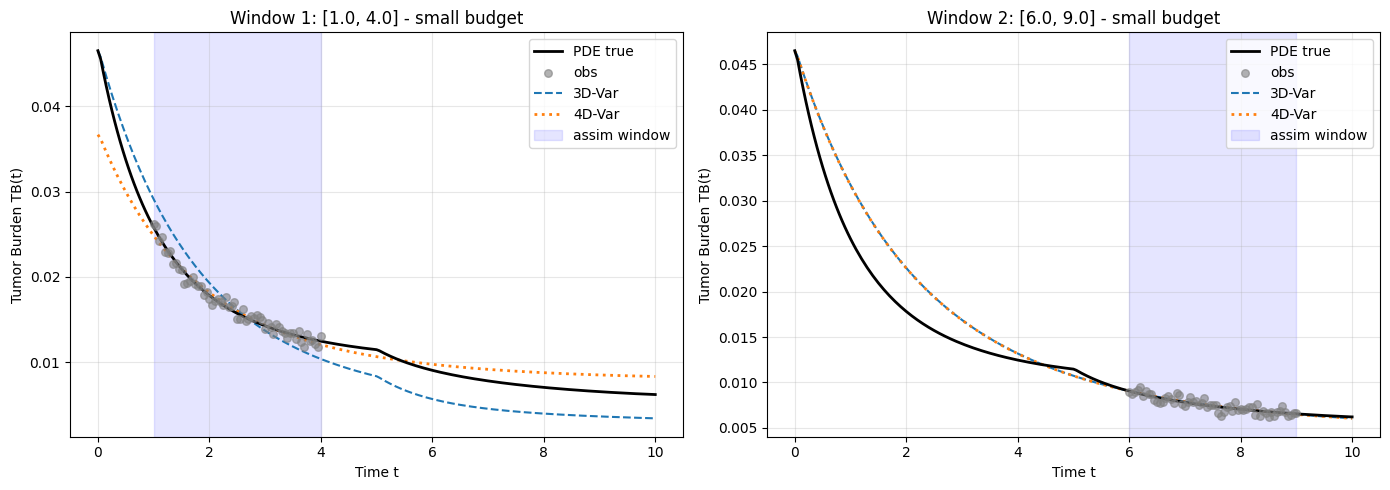

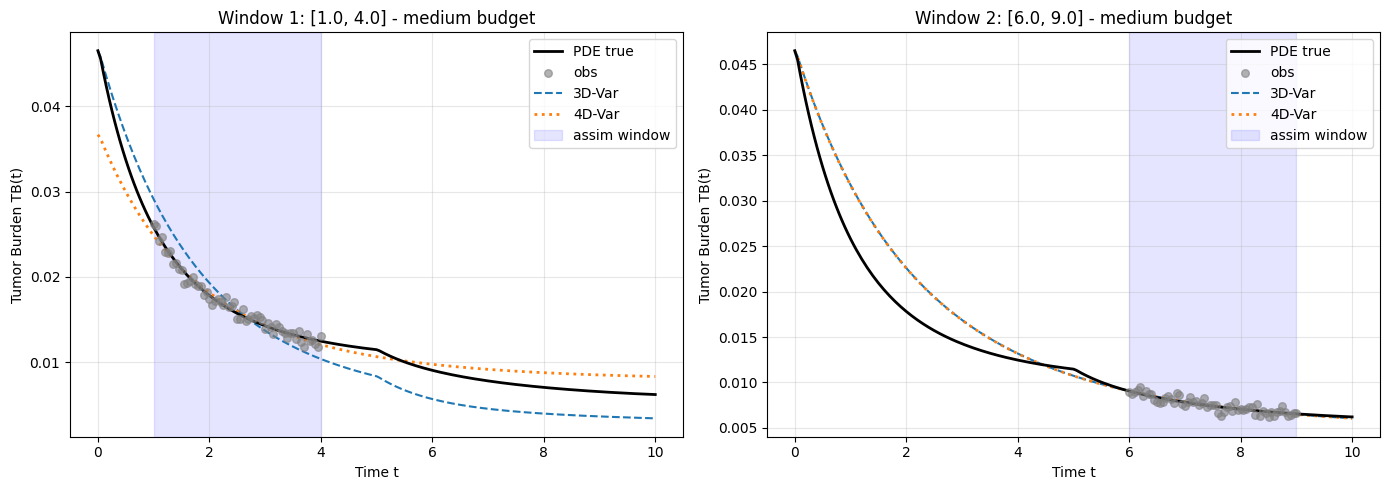

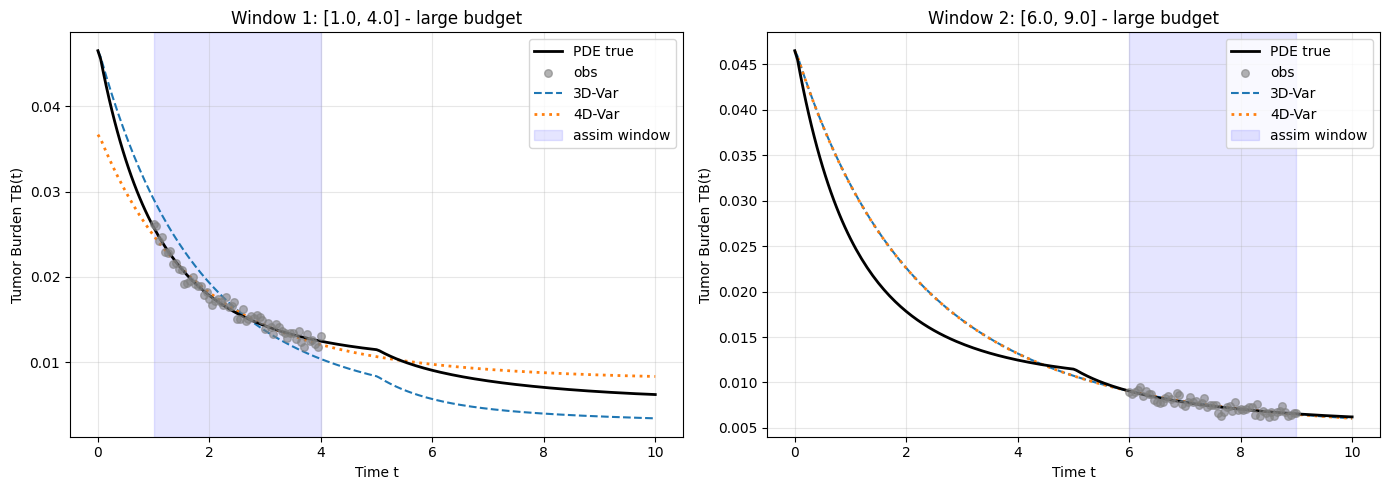

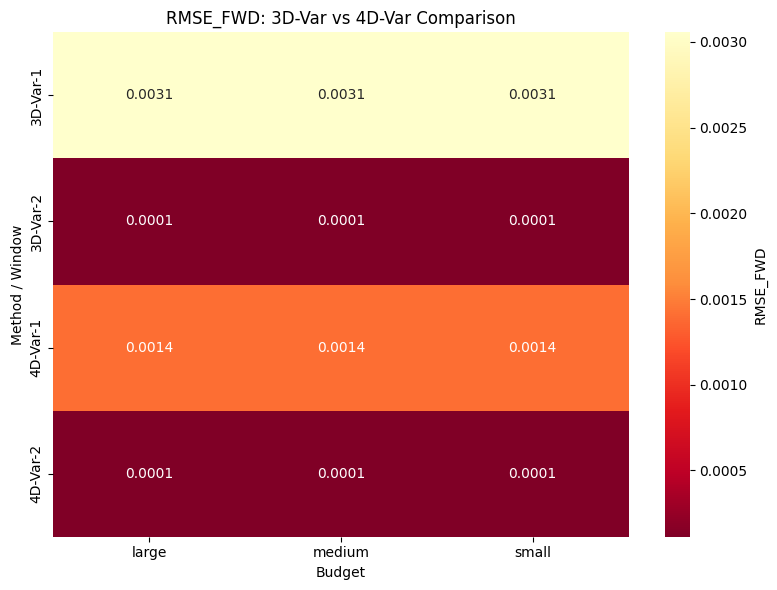

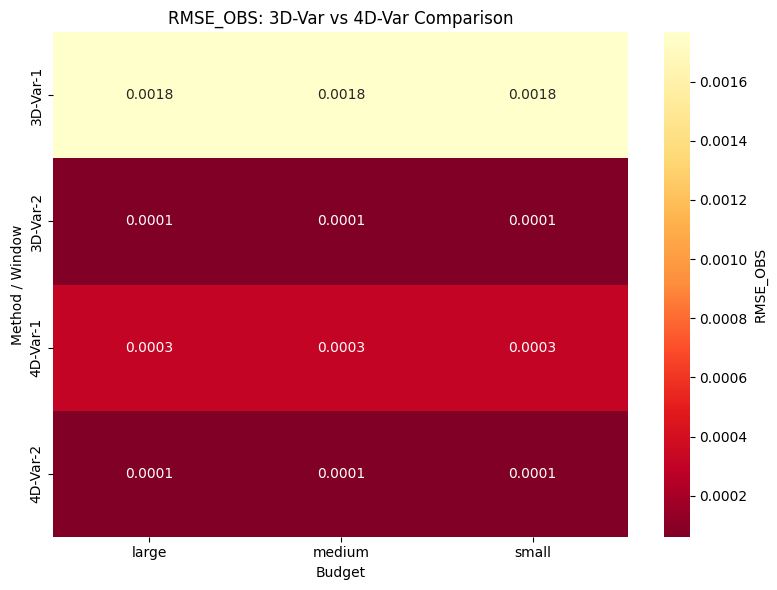

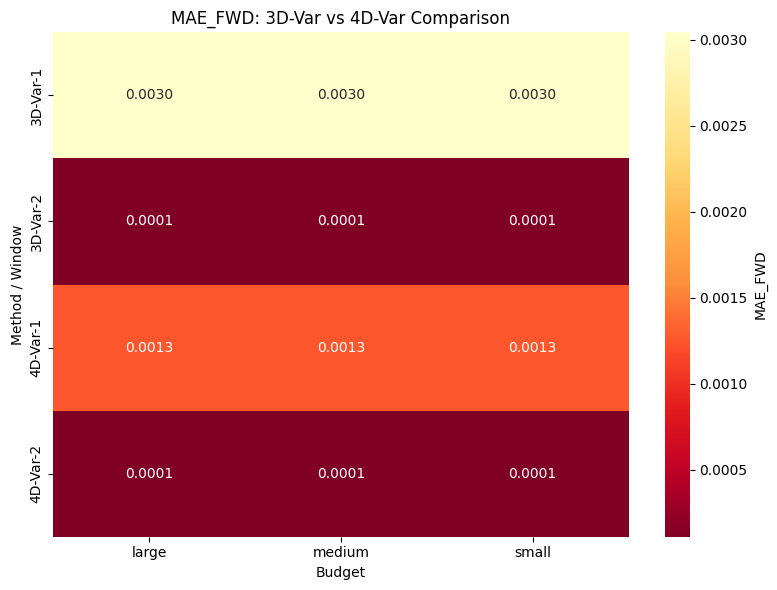

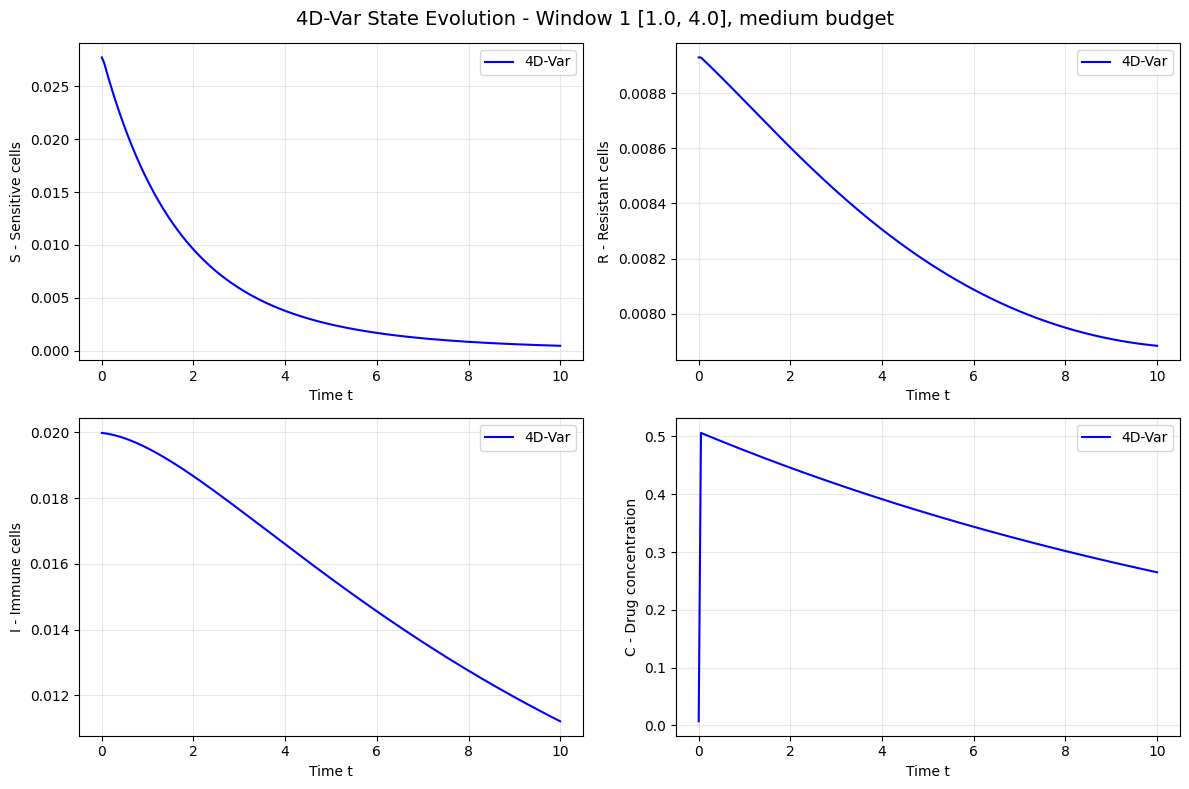

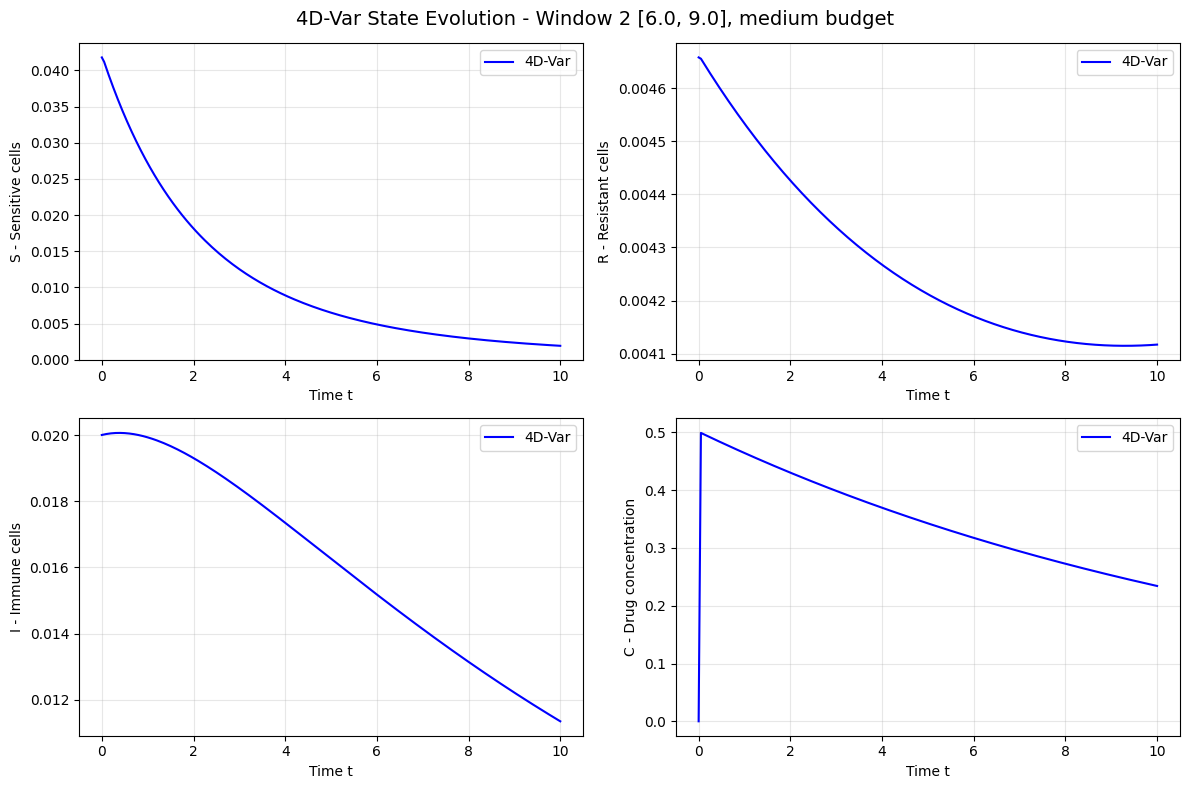

In [34]:
# Generate visualizations
if SCIPY_OK:
    print("\n" + "="*60)
    print("Generating Visualization Plots")
    print("="*60)

    # Dual window comparison plots for all budgets
    for budget in ["small", "medium", "large"]:
        plot_dual_window_comparison(budget)

    # Performance heatmaps for key metrics
    for metric in ["rmse_fwd", "rmse_obs", "mae_fwd"]:
        plot_performance_heatmap(df_comparison, metric)

    # 4D-Var state evolution for medium budget, both windows
    plot_4dvar_state_evolution(budget="medium", window=1)
    plot_4dvar_state_evolution(budget="medium", window=2)

In [35]:
def test_4dvar_cost_function():
    """
    Test that 4D-Var cost function evaluates correctly.
    """
    print("\n[TEST] 4D-Var Cost Function Evaluation")

    # Setup test inputs
    mask_test = (t_true >= 1.0) & (t_true <= 4.0)
    y_obs_test = y_obs[mask_test]

    # Use reasonable initial state at t=0
    x0_test = np.array([0.04, 0.005, 0.02, 0.0])
    x0_b = np.array([0.04, 0.005, 0.02, 0.0])
    theta_test = np.array([0.8, 0.05, 0.2])
    B_std = np.array([0.01, 0.005, 0.01, 0.01])

    try:
        J = cost_J_4dvar(x0_test, theta_test, mask_test, y_obs_test,
                        x0_b, B_std, obs_sigma)
        print(f"   Cost function evaluates successfully: J = {J:.6f}")

        # Cost should be non-negative
        assert J >= 0, "Cost function should be non-negative"
        print(f"   Cost is non-negative")

        # Cost with same initial state as background should be smaller
        # than cost with different initial state
        x0_different = x0_b + np.array([0.01, 0.005, 0.0, 0.0])
        J_different = cost_J_4dvar(x0_different, theta_test, mask_test, y_obs_test,
                                  x0_b, B_std, obs_sigma)
        print(f"   Cost with different x0: J = {J_different:.6f}")

        return True
    except Exception as e:
        print(f"   FAILED: {e}")
        return False


def test_4dvar_convergence():
    """
    Test that 4D-Var optimization improves over background guess.
    """
    print("\n[TEST] 4D-Var Convergence")

    # Setup test window
    mask_test = (t_true >= 1.0) & (t_true <= 4.0)
    y_obs_test = y_obs[mask_test]

    # Background guess at t=0
    x0_guess = np.array([0.035, 0.008, 0.02, 0.0])
    theta_test = np.array([0.8, 0.05, 0.2])
    B_std = np.array([0.01, 0.005, 0.01, 0.01])

    # Initial cost
    J_initial = cost_J_4dvar(x0_guess, theta_test, mask_test, y_obs_test,
                            x0_guess, B_std, obs_sigma)
    print(f"  Initial cost J = {J_initial:.6f}")

    try:
        # Run optimization
        result = run_4dvar(mask_test, y_obs_test, theta_test, x0_guess,
                          B_std, obs_sigma, max_iter=50)

        J_final = result["J_opt"]
        print(f"  Final cost J = {J_final:.6f}")
        print(f"  Cost reduction: {J_initial - J_final:.6f}")
        print(f"  Iterations: {result['nit']}")
        print(f"  Success: {result['success']}")

        # Optimization should improve (reduce) cost
        if J_final < J_initial:
            print(f"   Optimization reduced cost")
        else:
            print(f"  ⚠ Warning: Cost did not reduce (may already be at minimum)")

        return True
    except Exception as e:
        print(f"   FAILED: {e}")
        return False


def test_physical_constraints():
    """
    Test that 4D-Var optimized states satisfy physical constraints (non-negativity).
    """
    print("\n[TEST] Physical Constraints (Non-negativity)")

    all_pass = True

    for window_num, results in [(1, fourvar_results_win1), (2, fourvar_results_win2)]:
        print(f"\n  Window {window_num}:")

        for budget, res in results.items():
            # Check initial state
            x0_opt = res["x0_opt"]
            states = {
                "S": res["S_opt"],
                "R": res["R_opt"],
                "I": res["I_opt"],
                "C": res["C_opt"]
            }

            # Check x0 non-negativity
            if np.all(x0_opt >= 0):
                print(f"     {budget}: Initial state x0 is non-negative")
            else:
                print(f"     {budget}: Initial state has negative values!")
                all_pass = False

            # Check trajectory non-negativity
            for state_name, state_vals in states.items():
                if np.all(state_vals >= -1e-10):  # Allow small numerical errors
                    min_val = np.min(state_vals)
                    print(f"     {budget}: {state_name} trajectory non-negative (min={min_val:.6e})")
                else:
                    min_val = np.min(state_vals)
                    print(f"     {budget}: {state_name} has negative values (min={min_val:.6e})!")
                    all_pass = False

    return all_pass

In [36]:
# Run tests
if SCIPY_OK:
    print("\n" + "="*60)
    print("Running 4D-Var Verification Tests")
    print("="*60)

    test_4dvar_cost_function()
    test_4dvar_convergence()
    test_physical_constraints()

    print("\n" + "="*60)
    print("All tests completed!")
    print("="*60)


Running 4D-Var Verification Tests

[TEST] 4D-Var Cost Function Evaluation
   Cost function evaluates successfully: J = 11336.487214
   Cost is non-negative
   Cost with different x0: J = 47873.307630

[TEST] 4D-Var Convergence
  Initial cost J = 11764.510080
  Final cost J = 100.769772
  Cost reduction: 11663.740308
  Iterations: 35
  Success: False
   Optimization reduced cost

[TEST] Physical Constraints (Non-negativity)

  Window 1:
     small: Initial state x0 is non-negative
     small: S trajectory non-negative (min=4.499720e-04)
     small: R trajectory non-negative (min=7.883561e-03)
     small: I trajectory non-negative (min=1.121111e-02)
     small: C trajectory non-negative (min=7.182313e-03)
     medium: Initial state x0 is non-negative
     medium: S trajectory non-negative (min=4.499720e-04)
     medium: R trajectory non-negative (min=7.883561e-03)
     medium: I trajectory non-negative (min=1.121111e-02)
     medium: C trajectory non-negative (min=7.182313e-03)
     lar

In [37]:
def evaluate_theta(tag, theta):
    TB_sim = simulate_TB_for_params(theta, t_true)
    out = {
        "rmse_obs": rmse(TB_sim[mask_obs], y_obs_win),
        "rmse_fwd": rmse(TB_sim[mask_fwd], TB_true[mask_fwd]),
        "rmse_bwd": rmse(TB_sim[mask_bwd], TB_true[mask_bwd]),
        "mae_obs":  mae(TB_sim[mask_obs], y_obs_win),
        "mae_fwd":  mae(TB_sim[mask_fwd], TB_true[mask_fwd]),
        "mae_bwd":  mae(TB_sim[mask_bwd], TB_true[mask_bwd]),
    }
    df = pd.DataFrame({"t": t_true, "TB_sim": TB_sim, "TB_true": TB_true, "TB_obs": y_obs})
    df.to_csv(f"out/sim_{tag}.csv", index=False)
    return out

summary_rows = []

# ABC
for k, res in abc_results.items():
    theta_map = res["theta_map"]
    met = evaluate_theta(f"abc_{k}", theta_map)
    summary_rows.append({"method":"ABC","budget":k, **met})

# 3D-Var (Window 1)
if SCIPY_OK:
    for k, res in var_results_win1.items():
        theta_opt = res["theta_opt"]
        met = evaluate_theta(f"3dvar_{k}", theta_opt)
        summary_rows.append({"method":"3D-Var","budget":k, **met})

df_sum = pd.DataFrame(summary_rows)
df_sum.to_csv("out/da_summary_metrics.csv", index=False)
print("[Zapisano] out/da_summary_metrics.csv")
df_sum

[Zapisano] out/da_summary_metrics.csv


,method,budget,rmse_obs,rmse_fwd,rmse_bwd,mae_obs,mae_fwd,mae_bwd
0,ABC,small,0.002253,0.000716,0.002895,0.001761,0.000638,0.002625
1,ABC,medium,0.001997,0.001060,0.002720,0.001554,0.000877,0.002471
2,ABC,large,0.002011,0.001420,0.002802,0.001615,0.001289,0.002549
3,3D-Var,small,0.001893,0.003056,0.002622,0.001614,0.003043,0.002390
4,3D-Var,medium,0.001893,0.003056,0.002622,0.001614,0.003043,0.002390
5,3D-Var,large,0.001893,0.003056,0.002622,0.001614,0.003043,0.002390


[Zapisano wykres] figs/da_trajectories_all.png


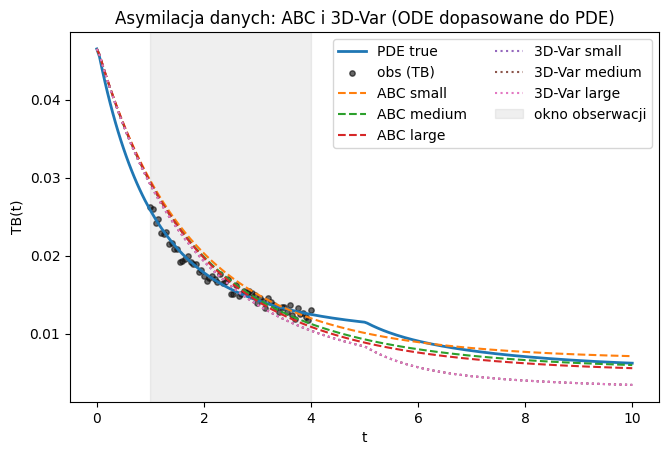

In [38]:
# Wykres porównawczy: „true”, obserwacje i dopasowania dla budżetów
plt.figure(figsize=(7.6,4.8))
plt.plot(t_true, TB_true, label="PDE true", lw=2)
plt.scatter(t_true[mask_obs], y_obs[mask_obs], s=15, c="k", label="obs (TB)", alpha=0.6)

colors = {"small":"C1", "medium":"C2", "large":"C3"}

# ABC
for k in abc_results.keys():
    df = pd.read_csv(f"out/sim_abc_{k}.csv")
    plt.plot(df["t"], df["TB_sim"], linestyle="--", label=f"ABC {k}")

# 3D-Var (Window 1)
if SCIPY_OK:
    for k in var_results_win1.keys():
        df = pd.read_csv(f"out/sim_3dvar_{k}.csv")
        plt.plot(df["t"], df["TB_sim"], linestyle=":", label=f"3D-Var {k}")

# Cieniowanie okna obserwacji
plt.axvspan(t_obs_start, t_obs_end, color="grey", alpha=0.12, label="okno obserwacji")
plt.xlabel("t"); plt.ylabel("TB(t)")
plt.title("Asymilacja danych: ABC i 3D-Var (ODE dopasowane do PDE)")
plt.legend(ncol=2)
savefig_f("da_trajectories_all.png")
plt.show()

[Zapisano wykres] figs/da_rmse_obs.png


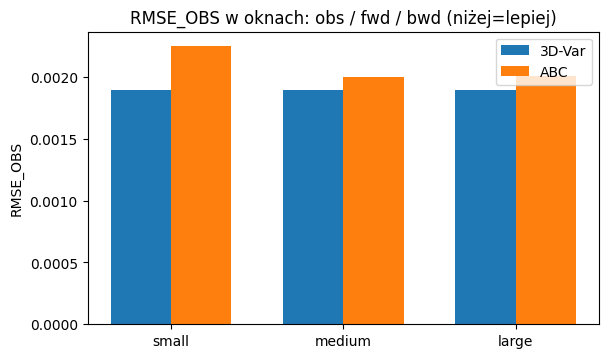

[Zapisano wykres] figs/da_rmse_fwd.png


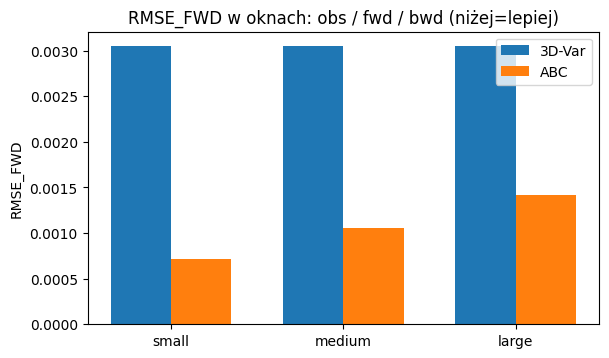

[Zapisano wykres] figs/da_rmse_bwd.png


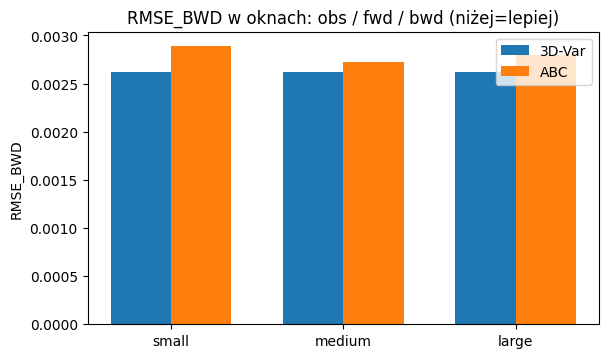

[Zapisano wykres] figs/da_mae_obs.png


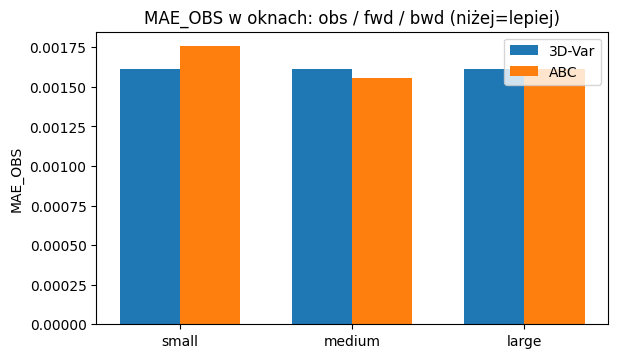

[Zapisano wykres] figs/da_mae_fwd.png


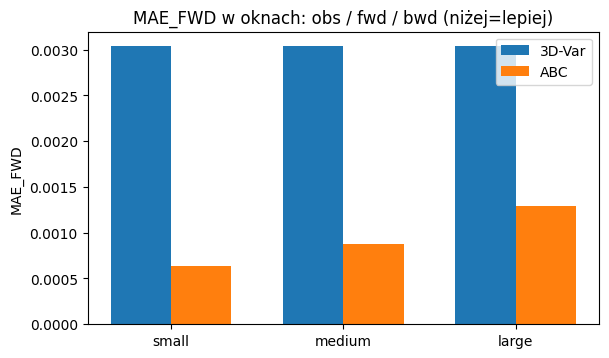

[Zapisano wykres] figs/da_mae_bwd.png


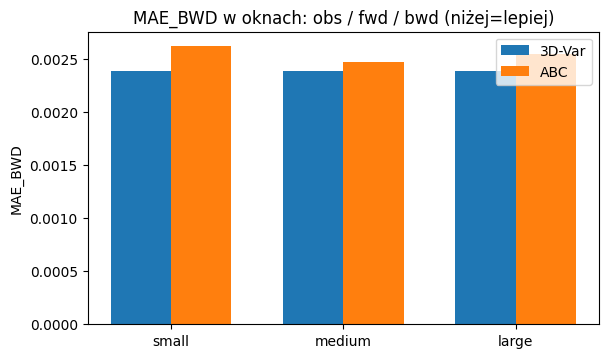

In [39]:
df_sum = pd.read_csv("out/da_summary_metrics.csv")

def plot_bar(metric, fname):
    plt.figure(figsize=(6.6,3.8))
    for i, method in enumerate(sorted(df_sum["method"].unique())):
        sub = df_sum[df_sum["method"]==method]
        x = np.arange(len(sub))
        plt.bar(x + i*0.35, sub[metric].values, width=0.35, label=method)
        plt.xticks(x + 0.35/2, sub["budget"].values)
    plt.ylabel(metric.upper())
    plt.title(f"{metric.upper()} w oknach: obs / fwd / bwd (niżej=lepiej)")
    plt.legend()
    savefig_f(fname)
    plt.show()

# Osobno trzy wykresy z RMSE i MAE w oknach fwd/bwd
for metric, fname in [("rmse_obs","da_rmse_obs.png"),
                      ("rmse_fwd","da_rmse_fwd.png"),
                      ("rmse_bwd","da_rmse_bwd.png")]:
    plot_bar(metric, fname)

for metric, fname in [("mae_obs","da_mae_obs.png"),
                      ("mae_fwd","da_mae_fwd.png"),
                      ("mae_bwd","da_mae_bwd.png")]:
    plot_bar(metric, fname)

## Opcjonalnie: 3D-Var dla PDE (mały budżet)
Dla PDE estymujemy tylko 2–3 parametry (np. $\alpha_S$, $\lambda$, $\mu_{\max}$) i pracujemy na siatce $48\times 48$ i krótszym horyzoncie. 
Kosztowo to droższe; dlatego proponujemy jeden budżet (np. `small`).

[PDE 3D-Var] start optymalizacji (small budget)
[Zapisano JSON] out/3dvar_pde_small_summary.json
[Zapisano wykres] figs/da_pde_3dvar_small.png


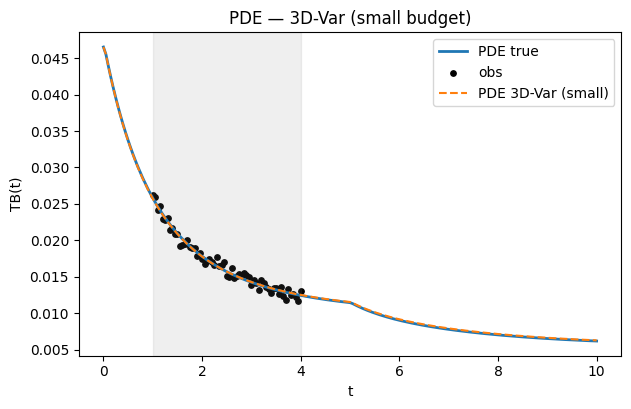

In [40]:
if PDE_OK and SCIPY_OK:
    pde_param_order = ["alpha_S", "lam", "mu_max"]
    pde_bounds = {"alpha_S": (0.4,1.2), "lam": (0.05,0.5), "mu_max": (0.0,0.1)}
    theta_b_pde = np.array([0.8, 0.2, 0.05])
    B_std_pde = np.array([0.3, 0.15, 0.05])

    def simulate_pde_TB(theta):
        p_loc = Params(**vars(p_true))
        for v, name in zip(theta, pde_param_order):
            setattr(p_loc, name, float(v))
        grid = Grid(Nx=48, Ny=48, Lx=1.0, Ly=1.0)
        (S_end, R_end, I_end, C_end), traj, info = run_simulation(
            solver_name="semi_implicit", grid=grid, p=p_loc,
            T=T_end, dt=None, save_every=max(1,len(t_true)//120), theta=0.5
        )
        t_traj = np.array([row["t"] for row in traj])
        TB_traj = np.array([row["tumor_burden"] for row in traj])
        return np.interp(t_true, t_traj, TB_traj)

    def cost_J_pde(theta):
        Jb = np.sum(((theta - theta_b_pde)/B_std_pde)**2)
        TB_sim = simulate_pde_TB(theta)
        innov = (TB_sim[mask_obs] - y_obs_win)/obs_sigma
        Jo = np.sum(innov**2)
        return 0.5*(Jb + Jo)

    bounds = [(pde_bounds[n][0], pde_bounds[n][1]) for n in pde_param_order]
    print("[PDE 3D-Var] start optymalizacji (small budget)")
    opt = minimize(cost_J_pde, theta_b_pde, method="L-BFGS-B", bounds=bounds,
                   options={"maxiter": 60, "ftol": 1e-8})
    theta_opt_pde = opt.x
    TB_pde_fit = simulate_pde_TB(theta_opt_pde)
    pd.DataFrame({"t": t_true, "TB_pde_fit": TB_pde_fit, "TB_true": TB_true}).to_csv("out/sim_pde_3dvar_small.csv", index=False)
    save_json({"theta_opt_pde": theta_opt_pde.tolist(), "J": float(opt.fun)}, "out/3dvar_pde_small_summary.json")

    plt.figure(figsize=(7.0,4.2))
    plt.plot(t_true, TB_true, label="PDE true", lw=2)
    plt.scatter(t_true[mask_obs], y_obs[mask_obs], c="k", s=15, label="obs")
    plt.plot(t_true, TB_pde_fit, "--", label="PDE 3D-Var (small)")
    plt.axvspan(t_obs_start, t_obs_end, color="grey", alpha=0.12)
    plt.xlabel("t"); plt.ylabel("TB(t)")
    plt.title("PDE — 3D-Var (small budget)")
    plt.legend()
    savefig_f("da_pde_3dvar_small.png")
    plt.show()
else:
    print("Pominięto PDE 3D-Var (PDE_OK or SCIPY_OK = False).")

## Wnioski i checklist
- ABC i 3D-Var dopasowują ODE do obserwacji z PDE; wzrost budżetu poprawia jakość dopasowania i predykcji out-of-window (fwd/bwd).
- 3D-Var zwykle szybciej znajduje „MAP-like” rozwiązanie; ABC daje populację akceptowalnych parametrów (niepewność).
- Predykcja „w tył” (bwd) i „w przód” (fwd) pozwala pokazać, że model nie tylko interpoluje w oknie, ale przewiduje trend poza nim.
- (Opcjonalnie) 3D-Var dla PDE z małym budżetem potwierdza zgodność trendów, lecz jest kosztowny.

**Pliki do prezentacji:**
- `figs/da_trajectories_all.png` – trajektorie true/obs/ABC/3D-Var + okno.
- `figs/da_rmse_obs.png`, `figs/da_rmse_fwd.png`, `figs/da_rmse_bwd.png`,
  `figs/da_mae_obs.png`, `figs/da_mae_fwd.png`, `figs/da_mae_bwd.png`.
- (opcjonalnie) `figs/da_pde_3dvar_small.png`.

**Pliki danych:**
- `out/da_observations.csv` – „true” TB i obserwacje.
- `out/abc_*_summary.json`, `out/3dvar_*_summary.json` – parametry i koszty.
- `out/sim_*.csv`, `out/da_summary_metrics.csv` – trajektorie i metryki.